In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import math
from statsmodels.formula.api import gls, ols
from statsmodels.stats import multitest

# import own python helper functions
from helpers.stats import calculate_cohens_d, association_with_volume, my_ancova

In [39]:
# define directories
data_dir = 'data/post_exclusion'

out_dir_stats = 'analysis/stats'
out_dir_plots = 'analysis/figures'
os.makedirs(out_dir_stats, exist_ok=True)
os.makedirs(out_dir_plots, exist_ok=True)

In [40]:
# figure settings: size figure according to manuscript requirements
cm_to_inch = 1/2.54
figsize_x = 19 * cm_to_inch
figsize_y = figsize_x/2

sns.set(style = "darkgrid")

# Load data and define variables

In [41]:
# load data
data = pd.read_csv(os.path.join(data_dir, 'CombinedThalamicNucleiCorrected_combinedHemis.csv'))
data_preterm = data[data['blsgroup']==1]
data_fullterm = data[data['blsgroup']==2]
print(data.shape)

(175, 23)


In [42]:
# Nuclei and variable lists
nuclei_groups = ['Anterior', 'Lateral', 'Ventral', 'Intralaminar', 'Medial', 'Pulvinar']

# Birth-related variables
birth_vars = ['GA', 'BW', 'inti']

# Behavioural variables
beh_vars = ['wie_gesiq']

## 3.2. VP/VLBW adults show consistently lower volume across thalamic nuclei

In [43]:
ancova_results = my_ancova(nuclei_groups, data, covars=['sex','Age_at_scan', 'TIV_corrected'])
ancova_results.to_csv(os.path.join(out_dir_stats, 'ANCOVA_results_subregions.csv'), index=False)  
ancova_results

,roi,F-value,p-value,p-fdr,Cohens d
0,Anterior,10.807175,1.228524e-03,1.228524e-03,-0.723997
1,Lateral,29.741742,1.716053e-07,2.059263e-07,-1.004996
2,Ventral,34.459282,2.226522e-08,3.339783e-08,-1.120166
3,Intralaminar,41.325661,1.252640e-09,7.515838e-09,-1.139659
4,Medial,36.575590,9.066169e-09,1.813234e-08,-1.130684
5,Pulvinar,39.310574,2.882798e-09,8.648393e-09,-1.138380


### Figure 2A

In [44]:
# enter group naming
df = data.copy()
df['blsgroup'] = df['blsgroup'].replace([1,2], ['Preterm', 'Full-term'])

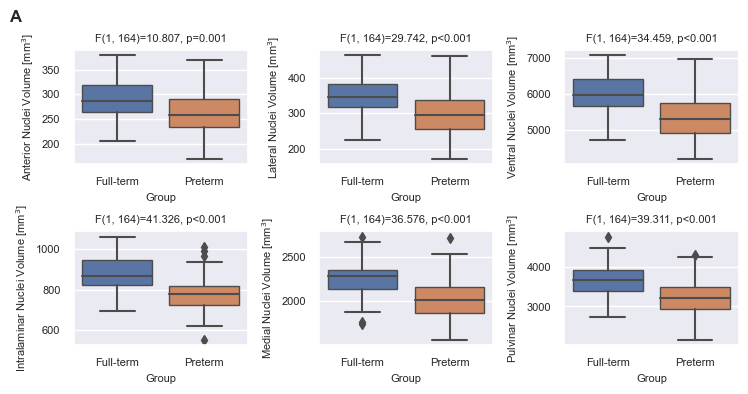

In [45]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(figsize_x, figsize_y))
plt.rc('font', size=8)
x='blsgroup'
order=['Full-term', 'Preterm']

for i, ax in enumerate(ax.flat):
    roi_name = nuclei_groups[i]
    y = nuclei_groups[i]
    
    # save relevant F-value and p_fdr
    F_ancova = round(ancova_results['F-value'][i], 3)
    fdr_ancova = ancova_results['p-fdr'][i]
    
    # set sign in image description accordingly
    if fdr_ancova < 0.001:
        fdr_ancova = 0.001
        sign = "<"
    else:
        sign = "="
        fdr_ancova = round(fdr_ancova, 3)
    
    # plot the results
    plot = sns.boxplot(data=df, x=x, y=y, order=order, palette='deep', ax=ax, boxprops=dict(linewidth=1))
    plot.set_xlabel('Group', fontsize=8)
    plot.set_ylabel(f'{roi_name} Nuclei Volume [mm$^3$]', fontsize=8)
    plot.set_title('F(1, 164)={0}, p{1}{2}'.format(F_ancova, sign, fdr_ancova), fontsize=8)
    plot.tick_params(axis='both', which='both', labelsize=8)

plt.tight_layout()

# add "A"
fig.text(0.01, 1, "A", fontsize=12, fontweight='bold')

plt.savefig(os.path.join(out_dir_plots, 'Figure2A.tif'), dpi=800, format='tif')

## Volumetric differences in thalamic subregions and their association with INTI

In [46]:
# relate nuclei volume with INTI, GA, and BW in preterm subjects
association_df = pd.DataFrame(columns=['variable', 'nucleus', 'Tstatistic', 
                                         'coef', 'R2', 'pvalue', 'pfdr'])

for variable in birth_vars:
    for nucleus in nuclei_groups:
        summary_df = association_with_volume(nucleus, variable, data_preterm)
        association_df = pd.concat([summary_df, association_df], axis=0, ignore_index=True)
    
# add FDR correction
association_df['pfdr'] = multitest.fdrcorrection(association_df['pvalue'])[1]

# sort and save
association_df = association_df.sort_index(ascending=False)
association_df = association_df.reset_index(drop=True)
association_df.to_csv(os.path.join(out_dir_stats, 'preterm_glm_summary_stats_birthvars.csv'), index=False)
association_df

,variable,nucleus,Tstatistic,coef,R2,pvalue,pfdr
0,GA,Anterior,0.518939,1.004956,0.292222,0.605272,0.640877
1,GA,Lateral,1.754597,5.190780,0.175237,0.083255,0.162956
2,GA,Ventral,1.231333,31.158609,0.469223,0.221898,0.307243
3,GA,Intralaminar,0.619253,2.050733,0.510142,0.537554,0.624221
4,GA,Medial,1.378830,14.221471,0.284806,0.171889,0.281272
5,GA,Pulvinar,2.432216,45.758763,0.436751,0.017298,0.049325
6,BW,Anterior,-2.508093,-0.033833,0.342781,0.014214,0.049325
7,BW,Lateral,-1.967532,-0.041872,0.183221,0.052677,0.118523
8,BW,Ventral,-0.593051,-0.109285,0.461334,0.554863,0.624221
9,BW,Intralaminar,-0.877786,-0.020962,0.512549,0.382756,0.492114


### Figure 2B

In [47]:
association_inti = association_df[association_df['variable']=='inti']
association_inti

,variable,nucleus,Tstatistic,coef,R2,pvalue,pfdr
12,inti,Anterior,-2.392290,-2.664055,0.343934,0.019182,0.049325
13,inti,Lateral,-3.144795,-5.342716,0.240226,0.002362,0.014171
14,inti,Ventral,-3.401173,-48.403554,0.530675,0.001067,0.009599
15,inti,Intralaminar,-1.714111,-3.328500,0.528988,0.090531,0.162956
16,inti,Medial,-2.963190,-17.257819,0.342050,0.004049,0.018222
17,inti,Pulvinar,-3.429678,-37.149181,0.474499,0.000974,0.009599


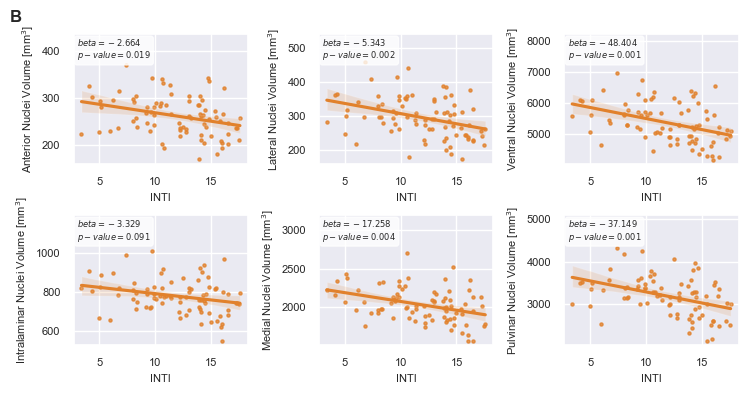

In [48]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(figsize_x, figsize_y))
plt.rc('font', size=8)

for i, ax in enumerate(ax.flat):
    plot=sns.regplot(x=data_preterm['inti'], y=data_preterm[nuclei_groups[i]], color='#E1812C', ax=ax,
                    scatter_kws={'s': 5})
    plot.set(ylim=(None, max(data_preterm[nuclei_groups[i]])*1.18))
    plot.set_xlabel('INTI', fontsize=8)
    plot.set_ylabel(nuclei_groups[i]+' Nuclei Volume [mm$^3$]', fontsize=8)
    
    # add textbox
    nuc_results = association_inti.iloc[i,:]
    
    textstr = '\n'.join((
        r'$beta=%.3f$' % (nuc_results.coef),
        r'$p-value=%.3f$' % (nuc_results.pvalue)))
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plot.text(0.02, 0.98, textstr, transform=plot.transAxes, fontsize=6,verticalalignment='top',bbox=props)
    
    ax.tick_params(axis='x', labelsize=8)  # Setting xtick size
    ax.tick_params(axis='y', labelsize=8)  # Setting ytick size
    
plt.tight_layout()

# add "b"
fig.text(0.01, 1, "B", fontsize=12, fontweight='bold')

plt.savefig(os.path.join(out_dir_plots, 'Figure2B.tif'), dpi=800, format='tif')

## 3.3. Lateral, medial, and pulvinar volume reductions were related to worse cognitive performance in VP/VLBW adults

In [49]:
# relate nuclei volume with INTI in preterm subjects
association_df = pd.DataFrame(columns=['variable', 'nucleus', 'Tstatistic', 
                                         'coef', 'R2', 'pvalue', 'pfdr'])

for nucleus in nuclei_groups:
    summary_df = association_with_volume(nucleus, 'wie_gesiq', data_preterm)
    association_df = pd.concat([summary_df, association_df], axis=0, ignore_index=True)
    
# add FDR correction
association_df['pfdr'] = multitest.fdrcorrection(association_df['pvalue'])[1]

# sort and save
association_df = association_df.sort_index(ascending=False)
association_df = association_df.reset_index(drop=True)
association_df.to_csv(os.path.join(out_dir_stats, 'preterm_glm_summary_stats_IQ.csv'), index=False)
association_df = association_df.sort_values('pfdr')
association_df

,variable,nucleus,Tstatistic,coef,R2,pvalue,pfdr
1,wie_gesiq,Lateral,2.067894,1.078115,0.220719,0.042099,0.084198
4,wie_gesiq,Medial,2.179199,4.077059,0.313670,0.032457,0.084198
5,wie_gesiq,Pulvinar,2.129685,7.403838,0.445075,0.036479,0.084198
2,wie_gesiq,Ventral,1.914231,8.708133,0.502213,0.059406,0.089108
3,wie_gesiq,Intralaminar,1.488762,0.868459,0.556954,0.140743,0.168892
0,wie_gesiq,Anterior,0.287010,0.101481,0.310004,0.774896,0.774896


### Figure 3

In [50]:
significant_nuclei=['Lateral', 'Medial', 'Pulvinar']

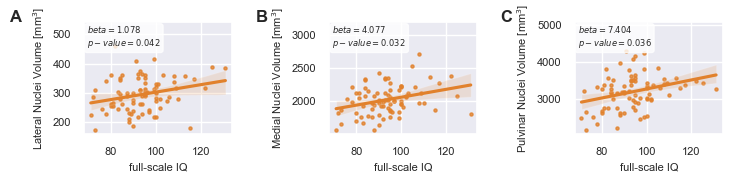

In [51]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(figsize_x, figsize_y/2))
plt.rc('font', size=8)
letters = ['A', 'B', 'C']

for i, ax in enumerate(ax.flat):
    plot=sns.regplot(x=data_preterm['wie_gesiq'], y=data_preterm[significant_nuclei[i]], color='#E1812C', ax=ax,
                    scatter_kws={'s': 5})
    plot.set(ylim=(None, max(data_preterm[significant_nuclei[i]])*1.18))
    plot.set_xlabel('full-scale IQ', fontsize=8)
    plot.set_ylabel(significant_nuclei[i]+' Nuclei Volume [mm$^3$]', fontsize=8)
    
    # add textbox
    nuc_results = association_df.iloc[i,:]
    
    textstr = '\n'.join((
        r'$beta=%.3f$' % (nuc_results.coef),
        r'$p-value=%.3f$' % (nuc_results.pvalue)))
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plot.text(0.02, 0.98, textstr, transform=plot.transAxes, fontsize=6,verticalalignment='top',bbox=props)
    
    ax.tick_params(axis='x', labelsize=8)  
    ax.tick_params(axis='y', labelsize=8)  
    
    # add figure number
    ax.text(-0.5, 1, letters[i], fontsize=12, fontweight='bold',transform=ax.transAxes)
    
    
plt.tight_layout()
plt.savefig(os.path.join(out_dir_plots, 'Figure3.tif'), dpi=800, format='tif')